In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

import datetime
import os

import tensorflow as tf
print(tf.__version__)

import tensorflow_addons as tfa
print(tfa.__version__)

2.4.1
0.12.1


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import phenom

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use("ggplot")
# mpl.rcParams.update({"font.size": 16})

import multiprocessing as mp
import functools

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import wispy.lalutils
import wispy.model_utils
import wispy.callbacks
import wispy.resnet

import lalsimulation as lalsim

from sklearn.preprocessing import MinMaxScaler

In [3]:
import pugna.layers
import pugna.activations
import pugna.callbacks

from tensorflow.keras.utils import get_custom_objects
# https://stackoverflow.com/a/59789336/12840171
# this is the way to add custome activations - do not do 
# get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
# get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})
# instead to
# otherwise problems with saving and loading
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [4]:
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [5]:
def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

# define model

In [6]:
# need a function to create sub-networks
def build_subnetwork(input_tensor, units, activation='relu', n_blocks=1):
    """
    n_blocks >= 1
    """
    assert n_blocks >= 1, f"n_blocks must be >1, got {n_blocks}"

    # tmp = input_tensor
    tmp = tf.keras.layers.Dense(units, activation=activation)(input_tensor)

    x = tf.keras.layers.Dense(units, activation=activation)(input_tensor)
    # x = tfa.layers.GroupNormalization(groups=1)(x)
    # x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
    for _ in range(n_blocks):
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        # x = tfa.layers.GroupNormalization(groups=1)(x)
        # x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)

        x = tf.keras.layers.add([x, tmp])
        tmp = x

    # single output here?
    x = tf.keras.layers.Dense(1, activation='linear')(x)

    return x

In [7]:
# constant scale
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, scale, **kwargs):
        super(ScaleLayer, self).__init__()
        self.scale = scale
        
    def call(self, inputs):
        return inputs * self.scale
    
    def get_config(self):
        config = super(ScaleLayer, self).get_config()
        config.update({"scale": self.scale})
        return config


In [8]:
# uses scale * (1+delta_w) where delta_w is trainable
class ScaleLayer_Trainable(tf.keras.layers.Layer):
    def __init__(self, scale, name=None, **kwargs):
        super(ScaleLayer_Trainable, self).__init__(name=name)
        self.scale = scale
        
    def build(self, input_shape):
        self.delta_w = self.add_weight(shape=(input_shape[-1], 1), initializer=tf.keras.initializers.RandomNormal(), trainable=True, name="delta_w")
        
    def call(self, inputs):
        return inputs * self.scale * (1. + self.delta_w)

In [9]:
# uses a random, trainable scale
class ScaleLayer_Trainable_v2(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super(ScaleLayer_Trainable_v2, self).__init__(name=name)
        
    def build(self, input_shape):
        self.scale = self.add_weight(shape=(input_shape[-1], 1), initializer=tf.keras.initializers.RandomUniform(0, 100), trainable=True, name="delta_w")
        
    def call(self, inputs):
        return inputs * self.scale

In [10]:
TEST_X = tf.convert_to_tensor([[1.],[2.],[3.]])

In [11]:
TEST_X

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.],
       [2.],
       [3.]], dtype=float32)>

In [12]:
tmp2=ScaleLayer_Trainable(10)
tmp2(TEST_X)
print(tmp2.delta_w)
print(tmp2.scale*(1.+tmp2.delta_w))

<tf.Variable 'scale_layer__trainable/delta_w:0' shape=(1, 1) dtype=float32, numpy=array([[-0.05524122]], dtype=float32)>
tf.Tensor([[9.447588]], shape=(1, 1), dtype=float32)


In [13]:
ScaleLayer_Trainable(1)(TEST_X)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.9413623],
       [1.8827246],
       [2.824087 ]], dtype=float32)>

In [14]:
ScaleLayer(1)(TEST_X)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.],
       [2.],
       [3.]], dtype=float32)>

In [15]:
# this version supports variable number of units and blocks for each scale.
# the idea is that maybe smaller scales can cope with smaller networks
def build_model(
    input_shape = 1,
    output_shape = 1,
    units = [128],
    activation = 'relu',
    n_blocks = [2],
    scales = [1]
    ):
    assert len(scales) == len(n_blocks) == len(units), "units, n_blocks, scales must have same length"

    input_layer = tf.keras.Input(shape=(input_shape,))

    # create sub-networks
    xs = []
    for i, scale in enumerate(scales):
        scaled_input = ScaleLayer(scale)(input_layer)
#         scaled_input = ScaleLayer_Trainable(scale)(input_layer)
#         scaled_input = ScaleLayer_Trainable_v2()(input_layer)
        xs.append(build_subnetwork(scaled_input, units[i], activation, n_blocks[i]))

    if len(xs) > 1:
        output_layer = tf.keras.layers.add([x for x in xs])
    else:
        output_layer = xs[0]

    output_layer = tf.keras.layers.Dense(output_shape, activation="linear")(output_layer)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [16]:
def get_compiled_model(
        input_shape = 1,
        output_shape = 1,
        units = 128,
        n_blocks = 1,
        scales = [1],
        activation = 'relu',
        lr=1e-3,
        loss='mse',
        metrics=None
    ):
    model = build_model(
        input_shape=input_shape,
        output_shape=output_shape,
        units=units,
        activation=activation,
        n_blocks=n_blocks,
        scales=scales
        )

    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

# data generator

In [17]:
def gen_data(s1x=0.99, q=1, M=100, nproc=1, t_min=-500, validation=False, val_size=100):

    m1, m2 = phenom.m1_m2_M_q(M, q)
    ps = [wispy.lalutils.gen_td_wf_params(m1=m1, m2=m2, S1x=s1x, approximant=lalsim.SEOBNRv4P, f_min=5, distance=1e6)]

    times = []
    amp = []
    phase = []

    func = functools.partial(wispy.lalutils.gen_td_wf, t_max=60, t_min=t_min)

    with mp.Pool(nproc) as pool:
        returned = pool.map(func, ps)
#     print(len(returned))
#     print(len(returned[0]))
#     print(returned[0])
    for i in range(len(returned)):
        times.append(returned[i][0])
        amp.append(returned[i][1])
        phase.append(returned[i][2])



    # find common times and interpolate data onto common time grid
    dt_M = 0.5
    common_tmin = np.max(list(map(np.min, times)))
    common_tmax = np.min(list(map(np.max, times)))

    print(f"common_tmin = {common_tmin}")
    print(f"common_tmax = {common_tmax}")
    
    common_times = np.arange(common_tmin, common_tmax, dt_M)
    if validation is True:
        if val_size is None:
            val_size=len(common_times)
        common_times = np.random.uniform(low=common_tmin, high=common_tmax, size=val_size)

    ntimes = len(common_times)
    print(f"ntimes = {ntimes}")

    n_cases = len(ps)

    amps = np.zeros(shape=(n_cases, ntimes))
    phases = np.zeros(shape=(n_cases, ntimes))

    for i in range(n_cases):
        amps[i] = IUS(times[i], amp[i])(common_times)
        phases[i] = IUS(times[i], phase[i])(common_times)

    return common_times, amps, phases



In [18]:
# these pre-precessing steps are different because we only consider one waveform

def compute_pre_process(ys):
    ys = ys.copy()
    ys_max = np.max(ys)

    return ys_max

def apply_pre_process_forward(ys, y_max):
    ys = ys.copy()
    ys /= y_max

    return ys

def apply_pre_process_reverse(ys, y_max):
    ys = ys.copy()
    ys *= y_max

    return ys

In [19]:
%%time
common_times, amps, phases = gen_data(s1x=0.99, q=3, M=100, nproc=1, t_min=-500)

common_tmin = -499.65485542229254
common_tmax = 59.953849975320345
ntimes = 1120
CPU times: user 7.8 ms, sys: 12.3 ms, total: 20.1 ms
Wall time: 4.99 s


In [20]:
%%time
common_times_val, amps_val, phases_val = gen_data(s1x=0.99, q=3, M=100, nproc=1, t_min=-500, validation=True, val_size=None)

common_tmin = -499.65485542229254
common_tmax = 59.953849975320345
ntimes = 1120
CPU times: user 9.54 ms, sys: 15.3 ms, total: 24.8 ms
Wall time: 5.22 s


In [21]:
common_times.shape

(1120,)

In [22]:
common_times_val.shape

(1120,)

In [23]:
amps.shape

(1, 1120)

In [24]:
phases.shape

(1, 1120)

In [25]:
y_max = compute_pre_process(amps)

amps_prime = apply_pre_process_forward(amps, y_max)

# scale times to between -1, 1
times_scaler = MinMaxScaler(feature_range=(-1,1)) # this works better than (0,1)
# times_scaler = MinMaxScaler(feature_range=(0,1))
common_times_scaled = times_scaler.fit_transform(common_times[:, np.newaxis])[:,0]

# X = convert_input_for_ann(common_times, s1x_arr)
# X = convert_input_for_ann(common_times_scaled, s1x_arr)

X = common_times_scaled.copy().reshape(-1,1)
y = amps_prime.ravel().reshape(-1, 1)


amps_val_prime = apply_pre_process_forward(amps_val, y_max)
common_times_scaled_val = times_scaler.transform(common_times_val[:,np.newaxis])[:,0]

X_val = common_times_scaled_val.copy().reshape(-1,1)
y_val = amps_val_prime.ravel().reshape(-1, 1)



# X_val = convert_input_for_ann(common_times, s1x_arr_val)
# X_val = convert_input_for_ann(common_times_scaled, s1x_arr_val)

# amps_val_prime = apply_pre_process_forward(amps_val, y_mean, y_max)


# y_val = amps_val_prime.ravel().reshape(-1, 1)

# training data X and y

# # print(f"num cases: {s1x_arr.shape}")

# print(f"X.shape = {X.shape}")
# print(f"y.shape = {y.shape}")

# # validation data X and y

# print(f"num cases: {s1x_arr_val.shape}")

# print(f"X_val.shape = {X_val.shape}")
# print(f"y_val.shape = {y_val.shape}")

In [26]:
X.shape

(1120, 1)

In [27]:
y.shape

(1120, 1)

In [28]:
X_val.shape

(1120, 1)

In [29]:
y_val.shape

(1120, 1)

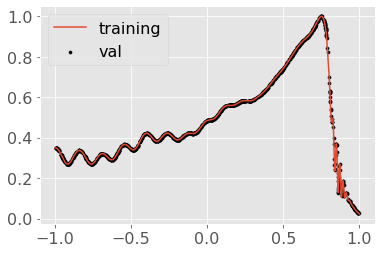

In [30]:
plt.figure()
plt.plot(X, y, label='training')
plt.scatter(X_val, y_val, label='val', s=10, c='k')
plt.legend()
# plt.xlim(0.5, 1)

In [31]:
sample_weight = np.ones(len(X))

mask = (X[:,0]>0.75) & (X[:,0]<=1)
sample_weight[mask] = 5

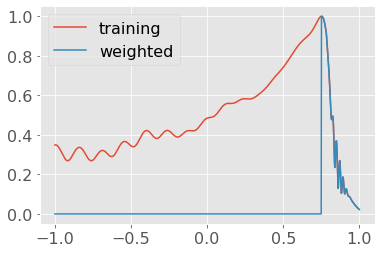

In [32]:
plt.figure()
plt.plot(X, y, label='training')

demo = np.zeros(len(X))
demo[mask] = 1

plt.plot(X, y[:,0]*demo, label='weighted')
plt.legend()
# plt.xlim(0.5, 1)

# fit

In [33]:
input_shape = X.shape[1]
output_shape = y.shape[1]
# units = [64, 256, 256]
# n_blocks = [1, 2, 2]
# scales = [1,10,100]
# activation = 's2relu'

# units = [512]
# n_blocks = [1]
# scales = [1]
# activation = 's2relu'

# units = [512]
# n_blocks = [1]
# scales = [10]
# activation = 's2relu'



#
# !!!!
# this with sample_wight was really good!
units = [256]
n_blocks = [2]
scales = [10]
activation = 's2relu'

# units = [256]
# n_blocks = [2]
# scales = [1]
# activation = 's2relu'


# units = [512]
# n_blocks = [1]
# scales = [100]
# activation = 's2relu'


# units = [128,128,128,128]
# n_blocks = [1,1,1,1]
# scales = [1,10,10,10]
# activation = 's2relu'


# scales = [1]
# activation='relu'

lr=1e-3
loss='mse'
# metrics=['mse']
metrics=None

In [34]:
model = get_compiled_model(
    input_shape=input_shape, output_shape=output_shape, units=units,
    scales=scales,
    activation=activation,
    n_blocks=n_blocks,
    lr=lr, loss=loss, metrics=metrics    
    )

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
scale_layer_1 (ScaleLayer)      (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          512         scale_layer_1[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          65792       dense_1[0][0]                    
______________________________________________________________________________________________

In [35]:
# tf.keras.utils.plot_model(model)

In [36]:
# epochs = 600
epochs = 2000
# epochs = 4000
# epochs = 5000
# epochs = 10000


batch_size = X.shape[0]
# batch_size = X.shape[0]//2
# batch_size = X.shape[0]//4
# batch_size = X.shape[0]//8
# batch_size = X.shape[0]//16

# batch_size = 256

print(f"batch_size: {batch_size}")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=40, min_lr=1e-4)


threshold = wispy.callbacks.ThresholdCallback(1e-6)
callbacks = [reduce_lr, pugna.callbacks.PrintDot(), threshold]
# callbacks = [reduce_lr, PrintDot()]
# callbacks = [pugna.callbacks.PrintDot(), threshold]

batch_size: 1120


In [37]:
starttime = datetime.datetime.now()

history = model.fit(
    X,
    y,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0,
    sample_weight=None
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print(f"\nThe time cost: {duration}")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

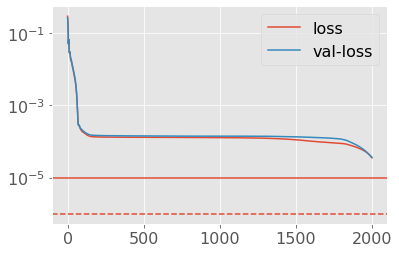

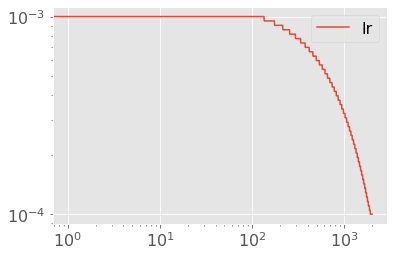

In [38]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val-loss')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-5)
plt.axhline(1e-6, ls='--')

if 'lr' in history.history.keys():
    plt.figure()
    plt.plot(history.history['lr'], label='lr')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')

In [39]:
model.layers[1].name

'scale_layer_1'

In [40]:
for layer in model.layers:
    if "scale" in layer.name:
        print(layer.scale)

10


In [41]:
# print(scales[0])
# print(model.layers[1].delta_w[0,0])
# print(scales[0] * (1.+model.layers[1].delta_w[0,0]))

In [42]:
# print(scales[1])
# print(model.layers[2].delta_w[0,0])
# print(scales[1] * (1.+model.layers[2].delta_w[0,0]))

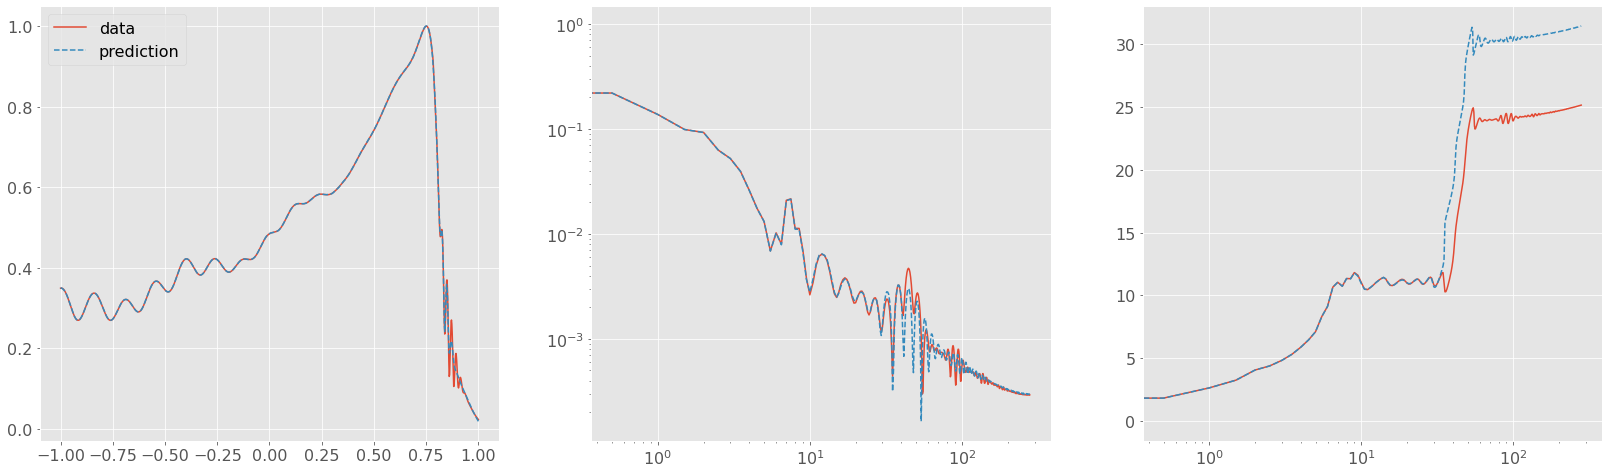

In [43]:
yhat = model.predict(common_times_scaled).T
xf, yf = compute_fft(common_times_scaled, amps_prime[0])
xfhat, yfhat = compute_fft(common_times_scaled, yhat[0])

plt.figure(figsize=(28, 8))
plt.subplot(1, 3, 1)
plt.plot(common_times_scaled, amps_prime[0], label='data')
plt.plot(common_times_scaled, yhat[0], ls='--', label='prediction')
# plt.xlim(0.75, 1)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(xf, np.abs(yf), label='data')
plt.plot(xfhat, np.abs(yfhat), ls='--', label='prediction')
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 3, 3)
plt.plot(xf, np.unwrap(np.angle(yf)), label='data')
plt.plot(xfhat, np.unwrap(np.angle(yfhat)), ls='--', label='prediction')
# plt.yscale('log')
plt.xscale('log')

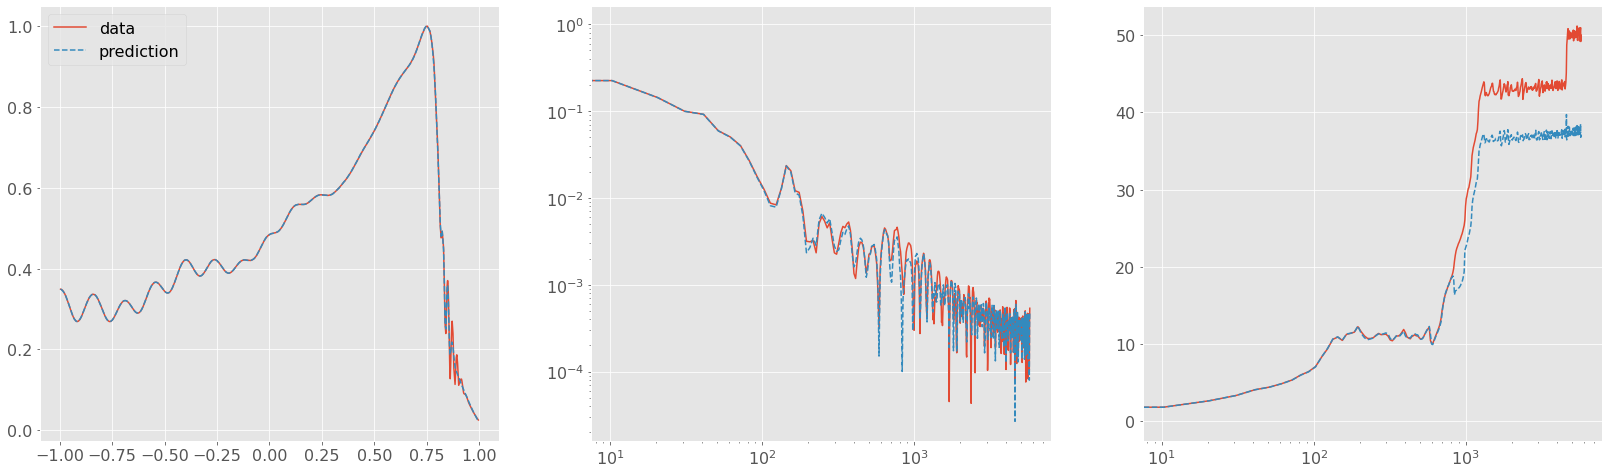

In [44]:
# sort validation data
# the FFT of non-uniform data is wrong i think so becareful interpreting this
# https://stackoverflow.com/a/2828121/12840171
tmp = np.stack((X_val[:,0], amps_val_prime[0]), axis=1)
X_val_sorted, amps_val_prime_sorted = tmp[tmp[:, 0].argsort()].T

# common_times_scaled_val_sorted = np.sort(common_times_scaled_val)
common_times_scaled_val_sorted = X_val_sorted.copy()

yhat = model.predict(common_times_scaled_val_sorted).T
xf, yf = compute_fft(common_times_scaled_val_sorted, amps_val_prime_sorted)
xfhat, yfhat = compute_fft(common_times_scaled_val_sorted, yhat[0])

plt.figure(figsize=(28, 8))
plt.subplot(1, 3, 1)
plt.plot(common_times_scaled_val_sorted, amps_val_prime_sorted, label='data')
plt.plot(common_times_scaled_val_sorted, yhat[0], ls='--', label='prediction')
# plt.xlim(-10, 60)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(xf, np.abs(yf), label='data')
plt.plot(xfhat, np.abs(yfhat), ls='--', label='prediction')
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 3, 3)
plt.plot(xf, np.unwrap(np.angle(yf)), label='data')
plt.plot(xfhat, np.unwrap(np.angle(yfhat)), ls='--', label='prediction')
# plt.yscale('log')
plt.xscale('log')

# with sample_weight

In [45]:
model_sw = get_compiled_model(
    input_shape=input_shape, output_shape=output_shape, units=units,
    scales=scales,
    activation=activation,
    n_blocks=n_blocks,
    lr=lr, loss=loss, metrics=metrics    
    )

model_sw.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
scale_layer_2 (ScaleLayer)      (None, 1)            0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 256)          512         scale_layer_2[0][0]              
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 256)          65792       dense_11[0][0]                   
____________________________________________________________________________________________

In [46]:
# tf.keras.utils.plot_model(model_sw)

In [47]:
# epochs = 600
epochs = 2000
# epochs = 4000
# epochs = 5000
# epochs = 10000


batch_size = X.shape[0]
# batch_size = X.shape[0]//2
# batch_size = X.shape[0]//4
# batch_size = X.shape[0]//8
# batch_size = X.shape[0]//16

# batch_size = 256

print(f"batch_size: {batch_size}")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=40, min_lr=1e-4)


threshold = wispy.callbacks.ThresholdCallback(1e-6)
callbacks = [reduce_lr, pugna.callbacks.PrintDot(), threshold]
# callbacks = [reduce_lr, PrintDot()]
# callbacks = [pugna.callbacks.PrintDot(), threshold]

batch_size: 1120


In [48]:
starttime = datetime.datetime.now()

history_sw = model_sw.fit(
    X,
    y,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0,
    sample_weight=sample_weight
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print(f"\nThe time cost: {duration}")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

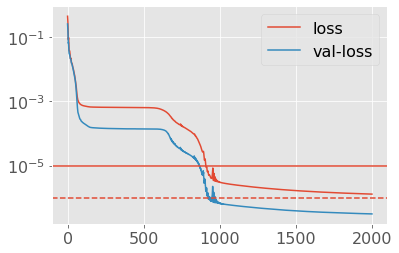

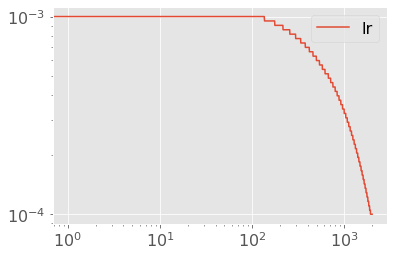

In [49]:
plt.figure()
plt.plot(history_sw.history['loss'], label='loss')
plt.plot(history_sw.history['val_loss'], label='val-loss')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-5)
plt.axhline(1e-6, ls='--')

if 'lr' in history_sw.history.keys():
    plt.figure()
    plt.plot(history_sw.history['lr'], label='lr')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')

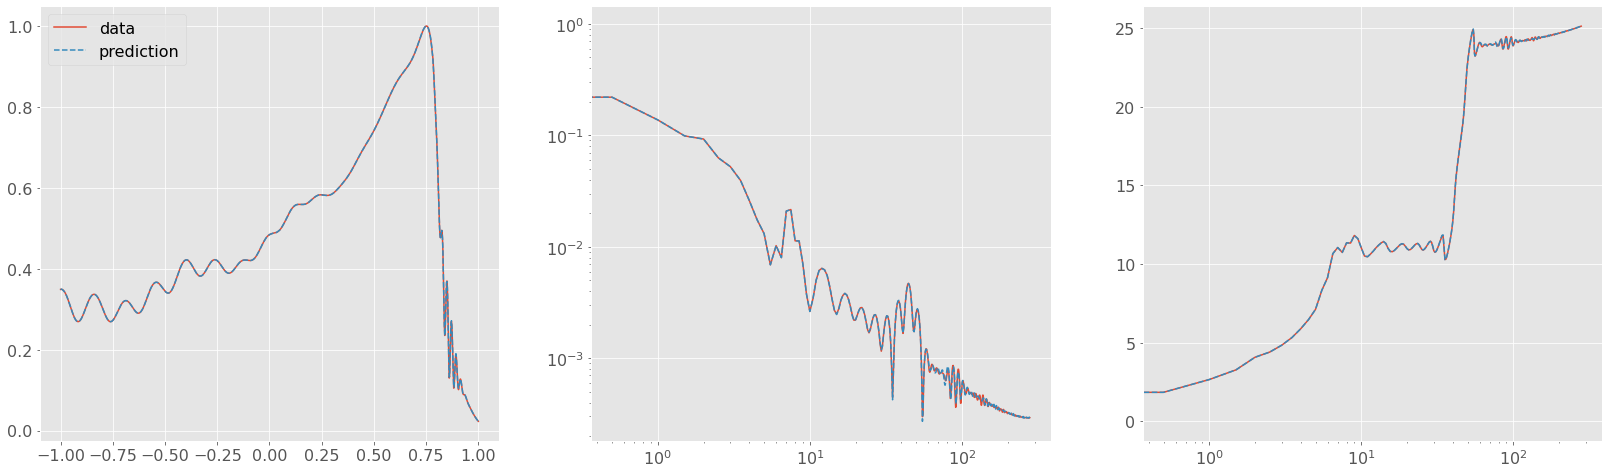

In [50]:
yhat = model_sw.predict(common_times_scaled).T
xf, yf = compute_fft(common_times_scaled, amps_prime[0])
xfhat, yfhat = compute_fft(common_times_scaled, yhat[0])

plt.figure(figsize=(28, 8))
plt.subplot(1, 3, 1)
plt.plot(common_times_scaled, amps_prime[0], label='data')
plt.plot(common_times_scaled, yhat[0], ls='--', label='prediction')
# plt.xlim(0.75, 1)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(xf, np.abs(yf), label='data')
plt.plot(xfhat, np.abs(yfhat), ls='--', label='prediction')
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 3, 3)
plt.plot(xf, np.unwrap(np.angle(yf)), label='data')
plt.plot(xfhat, np.unwrap(np.angle(yfhat)), ls='--', label='prediction')
# plt.yscale('log')
plt.xscale('log')

# comparison

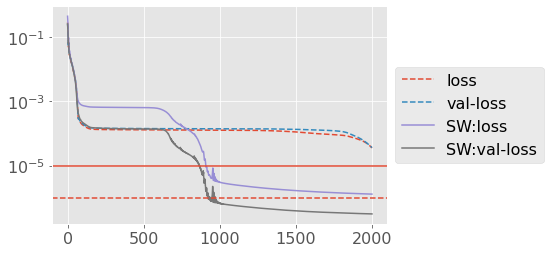

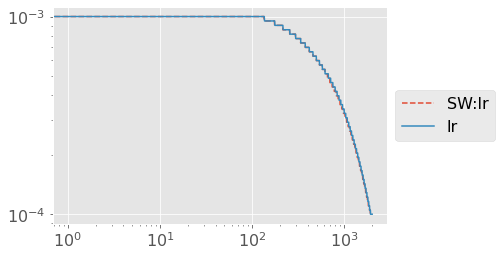

In [52]:
plt.figure()

plt.plot(history.history['loss'], label='loss', ls='--')
plt.plot(history.history['val_loss'], label='val-loss', ls='--')

plt.plot(history_sw.history['loss'], label='SW:loss')
plt.plot(history_sw.history['val_loss'], label='SW:val-loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-5)
plt.axhline(1e-6, ls='--')

if 'lr' in history_sw.history.keys():
    plt.figure()
    plt.plot(history.history['lr'], label='SW:lr', ls='--')
    plt.plot(history_sw.history['lr'], label='lr')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.yscale('log')
    plt.xscale('log')

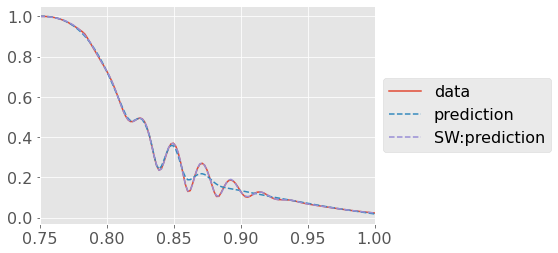

In [57]:
yhat = model.predict(common_times_scaled).T
yhat_SW = model_sw.predict(common_times_scaled).T

plt.figure()
plt.plot(common_times_scaled, amps_prime[0], label='data')
plt.plot(common_times_scaled, yhat[0], ls='--', label='prediction')
plt.plot(common_times_scaled, yhat_SW[0], ls='--', label='SW:prediction')
plt.xlim(0.75, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

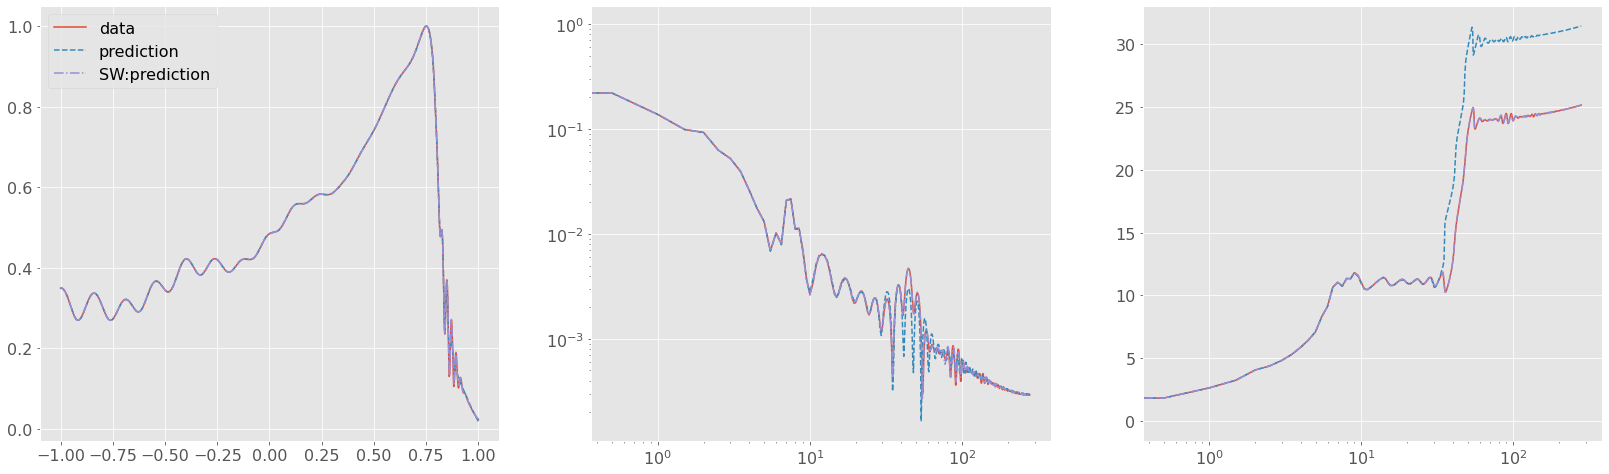

In [58]:
yhat = model.predict(common_times_scaled).T
yhat_SW = model_sw.predict(common_times_scaled).T
xf, yf = compute_fft(common_times_scaled, amps_prime[0])
xfhat, yfhat = compute_fft(common_times_scaled, yhat[0])
xfhat_SW, yfhat_SW = compute_fft(common_times_scaled, yhat_SW[0])

plt.figure(figsize=(28, 8))
plt.subplot(1, 3, 1)
plt.plot(common_times_scaled, amps_prime[0], label='data')
plt.plot(common_times_scaled, yhat[0], ls='--', label='prediction')
plt.plot(common_times_scaled, yhat_SW[0], ls='-.', label='SW:prediction')
# plt.xlim(0.75, 1)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(xf, np.abs(yf), label='data')
plt.plot(xfhat, np.abs(yfhat), ls='--', label='prediction')
plt.plot(xfhat_SW, np.abs(yfhat_SW), ls='-.', label='SW:prediction')
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 3, 3)
plt.plot(xf, np.unwrap(np.angle(yf)), label='data')
plt.plot(xfhat, np.unwrap(np.angle(yfhat)), ls='--', label='prediction')
plt.plot(xfhat_SW, np.unwrap(np.angle(yfhat_SW)), ls='-.', label='SW:prediction')
# plt.yscale('log')
plt.xscale('log')